In [103]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [104]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,80),
            nn.Tanh(),
            nn.Linear(80,120),
            nn.Tanh(),
            nn.Linear(120,120),
            nn.Tanh(),
            nn.Linear(120,80),
            nn.Tanh(),
            nn.Linear(80,80),
            nn.Tanh(),
            nn.Linear(80,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(0,1+self.h, self.h)
        t = torch.arange(0,6+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        self.len_bc = len(bc1) + len(bc2)
        self.len_ic = len(ic)
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = torch.sin(math.pi*ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2,y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_bc = self.criterion(y_pred[:self.len_bc],self.y_train[:self.len_bc])
        loss_ic = self.criterion(y_pred[self.len_bc:],self.y_train[self.len_bc:])
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

       

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_x_dX = torch.autograd.grad(
        du_dx, self.X,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_xx, u_xt]

        du_t_dX = torch.autograd.grad(
        du_dt, self.X,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_tx, u_tt]

        # Now extract individual components
        du_dxx = du_x_dX[:, 0]
        du_dtt = du_t_dX[:, 1]
        du_dxt = du_x_dX[:, 1]
        du_dtx = du_t_dX[:, 0]
        # c^2 = 1
        loss_pde = self.criterion(du_dtt, du_dxx)

        loss = loss_pde*1.3 + loss_bc*1.5 + loss_ic*1.2
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [107]:
# training
net = Net()
net.train()

100 0.13859188556671143
200 0.023996198549866676
300 0.026111993938684464
400 0.018697747960686684
500 0.018233168870210648
600 0.01726774498820305
700 0.01755853369832039
800 0.01676359586417675
900 0.04303852468729019
1000 0.01685657911002636
1100 0.016108740121126175
1200 0.015464335680007935
1300 0.01643701270222664
1400 0.015582661144435406
1500 0.015021405182778835
1600 0.01608404889702797
1700 0.015053988434374332
1800 0.01454681996256113
1900 0.06718579679727554
2000 0.015018421225249767
2100 0.014296228066086769
2200 0.013830163516104221
2300 0.014547672122716904
2400 0.013696381822228432
2500 0.013354001566767693
2600 0.013148881494998932
2700 0.013366909697651863
2800 0.012983812019228935
2900 0.012765360996127129
3000 0.012929814867675304
3100 0.012638166546821594
3200 0.01244847197085619
3300 0.014082368463277817
3400 0.012272351421415806
3500 0.012049635872244835
3600 0.012386396527290344
3700 0.011921579018235207
3800 0.011709373444318771
3900 0.011513913050293922
4000 0

In [108]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=80, bias=True)
    (1): Tanh()
    (2): Linear(in_features=80, out_features=120, bias=True)
    (3): Tanh()
    (4): Linear(in_features=120, out_features=120, bias=True)
    (5): Tanh()
    (6): Linear(in_features=120, out_features=80, bias=True)
    (7): Tanh()
    (8): Linear(in_features=80, out_features=80, bias=True)
    (9): Tanh()
    (10): Linear(in_features=80, out_features=1, bias=True)
  )
)

In [109]:
h = 0.01
k = 0.01

x = torch.arange(0,1+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [110]:
X

tensor([[0.0000, 0.0000],
        [0.0000, 0.0100],
        [0.0000, 0.0200],
        ...,
        [1.0000, 5.9800],
        [1.0000, 5.9900],
        [1.0000, 6.0000]], device='cuda:0')

In [111]:
X.shape

torch.Size([60701, 2])

In [112]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [113]:
y_pred1.shape

(101, 601)

In [114]:
y_pred1

array([[-0.0007902 , -0.00027378,  0.00016032, ...,  0.00134883,
         0.00159226,  0.00181888],
       [ 0.03097377,  0.03237663,  0.03367661, ...,  0.03029786,
         0.0315669 ,  0.03279928],
       [ 0.0626329 ,  0.06492649,  0.06709461, ...,  0.05922095,
         0.06150673,  0.06373535],
       ...,
       [ 0.06231801,  0.06362443,  0.06483577, ...,  0.05860291,
         0.05895333,  0.05916349],
       [ 0.03066943,  0.03153835,  0.03233276, ...,  0.02800034,
         0.02775858,  0.02740459],
       [-0.00105907, -0.00062497, -0.00024094, ..., -0.00271185,
        -0.00354912, -0.00448247]], dtype=float32)

In [115]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

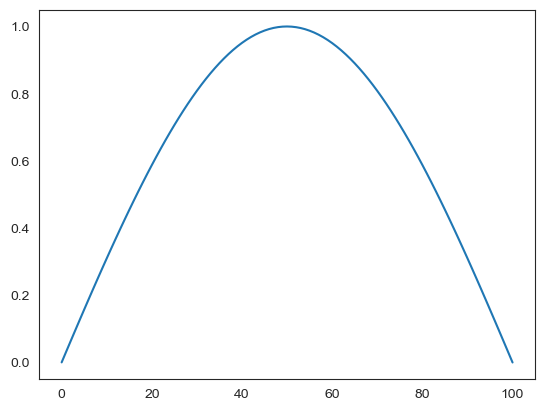

In [116]:
plt.plot(y_pred1[:,0])

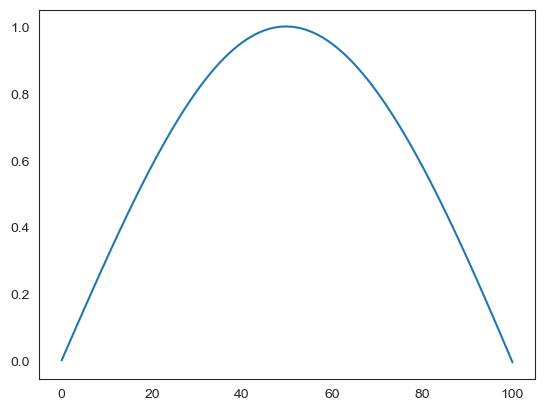

In [117]:
plt.plot(y_pred1[:,-1])

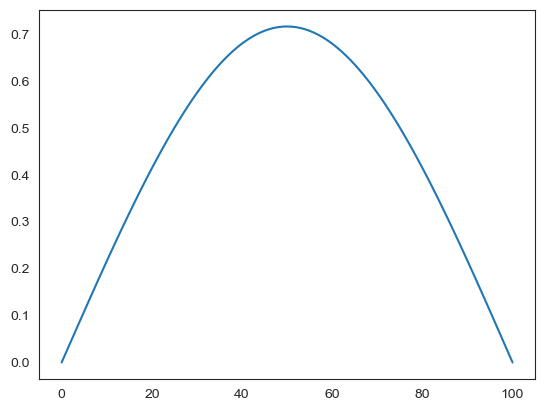

In [118]:
plt.plot(y_pred1[:,50])

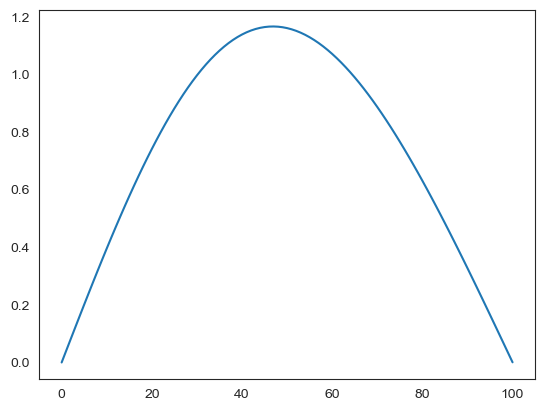

In [119]:
plt.plot(y_pred1[:,30])

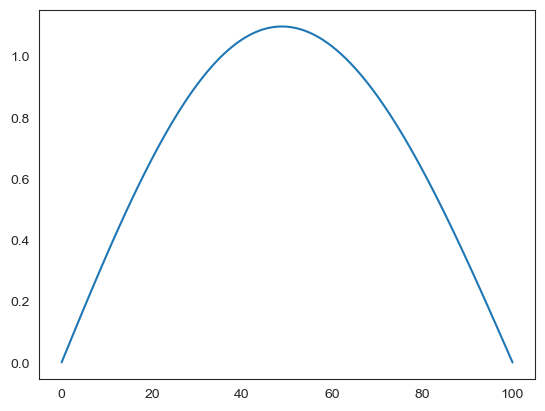

In [120]:
plt.plot(y_pred1[:,5])

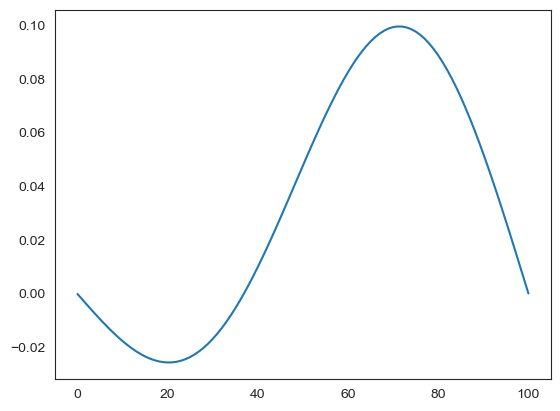

In [121]:
plt.plot(y_pred1[:,-30])

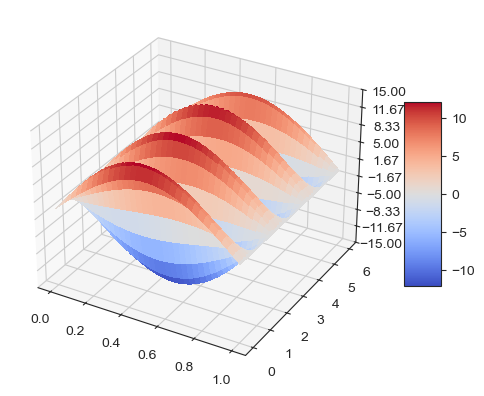

In [122]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15,15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [123]:
h = 0.01
k = 0.01

x = torch.arange(0,2+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [124]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [125]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

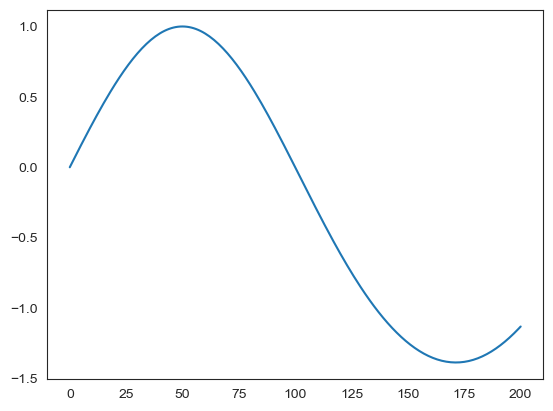

In [126]:
plt.plot(y_pred1[:,0])

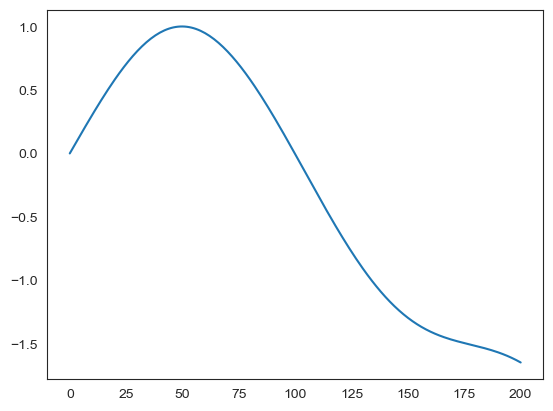

In [127]:
plt.plot(y_pred1[:,-1])

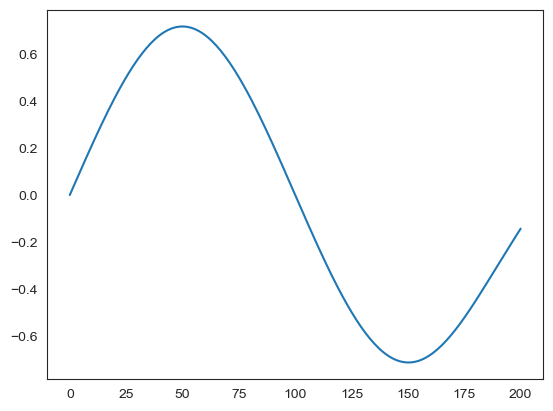

In [128]:
plt.plot(y_pred1[:,50])

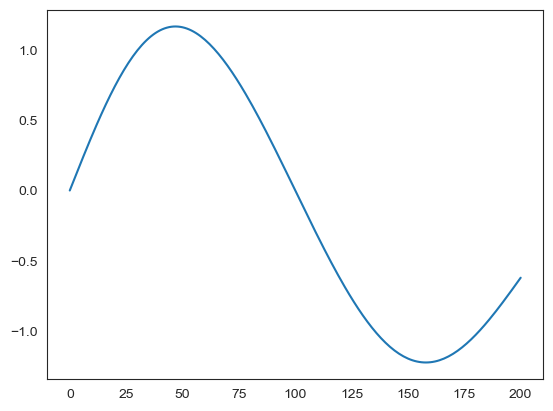

In [129]:
plt.plot(y_pred1[:,30])

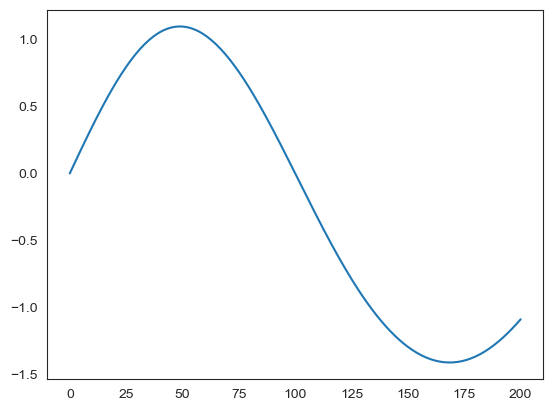

In [130]:
plt.plot(y_pred1[:,5])

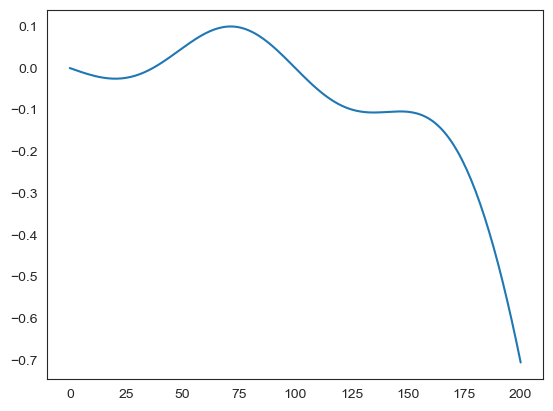

In [131]:
plt.plot(y_pred1[:,-30])

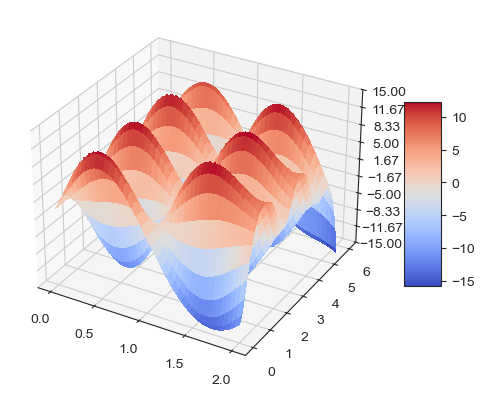

In [132]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15, 15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [133]:
h = 0.01
k = 0.01

x = torch.arange(0,3+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [134]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [135]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

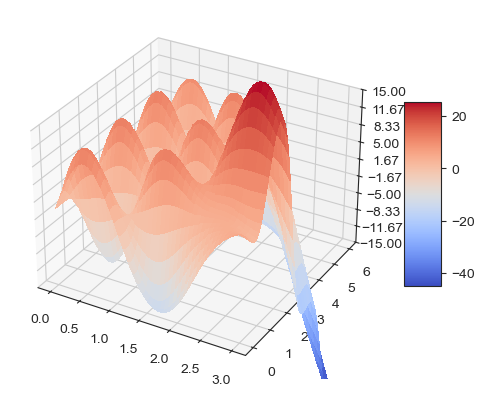

In [136]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15, 15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()